# Minimal Implementation: Homogeneous Projection for the Kepler Problem

This notebook demonstrates the implementation of homogeneous projection to preserve invariants in the 2D Kepler problem (planetary motion).

## What is covered

1. Preservation of **one homogeneous invariant** (the energy) using explicit homogeneous projection
2. Pseudo-preservation of **multiple nonlinear invariants** (energy + angular momentum + Runge-Lenz vector) 
3. Pseudo-preservation of multiple nonlinear invariants using **adaptive methods**

## The Kepler Problem

A planet orbiting the sun with gravitational force $F = -\frac{1}{r^2}$:

$$\ddot{\mathbf{r}} = -\frac{\mathbf{r}}{|\mathbf{r}|^3}$$

In phase space coordinates $(q_1, q_2, p_1, p_2)$ where $\mathbf{q} = (q_1, q_2)$ is position and $\mathbf{p} = (p_1, p_2)$ is momentum:

**Hamiltonian (Energy):**
$$H(q, p) = \frac{1}{2}(p_1^2 + p_2^2) - \frac{1}{\sqrt{q_1^2 + q_2^2}}$$

**Angular Momentum:**
$$L(q, p) = q_1 p_2 - q_2 p_1$$

**Runge-Lenz component:**
    $$A = p_2 L - \frac{q_1}{\sqrt{q_1^2 + q_2^2}}$$


All are conserved quantities that standard integrators fail to preserve exactly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
import sys
import os

# Add parent directory to path to import homproj
parent_dir = os.path.dirname(os.getcwd())
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# Import from the homproj package
from homproj import LinearHomogeneousProjector, HomogeneousProjector
from homproj.numeric import rk4, solve_ivp_fixed_step

## Define Kepler dynamics, invariants and initial conditions

In [2]:
def kepler_dynamics(t, y):
    """Kepler problem: dy/dt = f(y) where y = [q1, q2, p1, p2]"""
    q1, q2, p1, p2 = y
    r = (q1**2 + q2**2)**0.5
    r3 = r**3    
    dq1 = p1
    dq2 = p2
    dp1 = -q1 / r3
    dp2 = -q2 / r3
    return np.array([dq1, dq2, dp1, dp2])


def energy(q1, q2, p1, p2):
    kinetic = 0.5 * (p1**2 + p2**2)
    potential = -1.0 / (q1**2 + q2**2)**0.5
    return kinetic + potential

def angular_momentum(q1, q2, p1, p2):
    return q1 * p2 - q2 * p1

def runge_lenz_component(q1, q2, p1, p2):
    r = (q1**2 + q2**2)**0.5
    Lz = q1 * p2 - q2 * p1
    Ax = p2 * Lz - q1 / r
    return Ax

eccentricity = 0.8
y0 = np.array([(1 - eccentricity), 0.0, 0.0, np.sqrt((1 + eccentricity) / ((1 - eccentricity)))])


## Integration using standard RK4

The `homproj` package provides `solve_ivp_fixed_step` - a simple fixed-step integrator with RK4 by default:

In [3]:
h = 0.05
t_span = (0, 100)

print("Running standard RK4...")
t0 = time()
sol_std = solve_ivp_fixed_step(
    f=kepler_dynamics,
    t_span=t_span,
    y0=y0,
    method='rk4',
    h=h
)
time_std = time()-t0
print(f"Standard RK4 took {time_std:.3f} seconds")

Running standard RK4...
Standard RK4 took 0.040 seconds


## Homogeneous Energy-preserving projection

Use `LinearHomogeneousProjector` from `homproj` package. It requires:
- The invariant function
- Generator $\nu = \mathrm{diag}([-2, -2, 1, 1])$
- Degree $k = 2$
- Initial state

Energy $H$ is homogeneous w.r.t $\psi_t = e^{\nu t}$ : $H(e^{\nu t} y) = e^{2t} H(y)$

The following tests the method: 
$$\widehat{\Phi}_h = \psi_s\circ\Phi_h,$$
where $s = \frac{1}{2}\log\left(\frac{H(x)}{H(\Phi_h(x))}\right)$


In [4]:
# Create homogeneous projector for H
L_projector = LinearHomogeneousProjector(
    invariant=energy,
    generator=np.array([-2, -2, 1, 1]),  # [q1, q2, p1, p2]
    degree=2,
    initial_state=y0
)

# Create wrapped integrator: RK4 + projection
def rk4_with_hom_proj(x, h, f):
    x_new = rk4(x, h, f)
    return L_projector.project(x_new)



### Test: RK4 + Angular Momentum Projection

In [5]:
print("Running RK4 + angular momentum projection...")

t0 = time()
sol_proj = solve_ivp_fixed_step(
    f=lambda t, y: kepler_dynamics(t, y),
    t_span=t_span,
    y0=y0,
    method=rk4_with_hom_proj,
    h=h
)
time_proj = time()-t0
print(f"RK4 + linear homogeneous projection took {time_proj:.3f} seconds")

Running RK4 + angular momentum projection...
RK4 + linear homogeneous projection took 0.050 seconds


Text(0.5, 1.02, 'RK4 vs RK4 + Linear Homogeneous Projection')

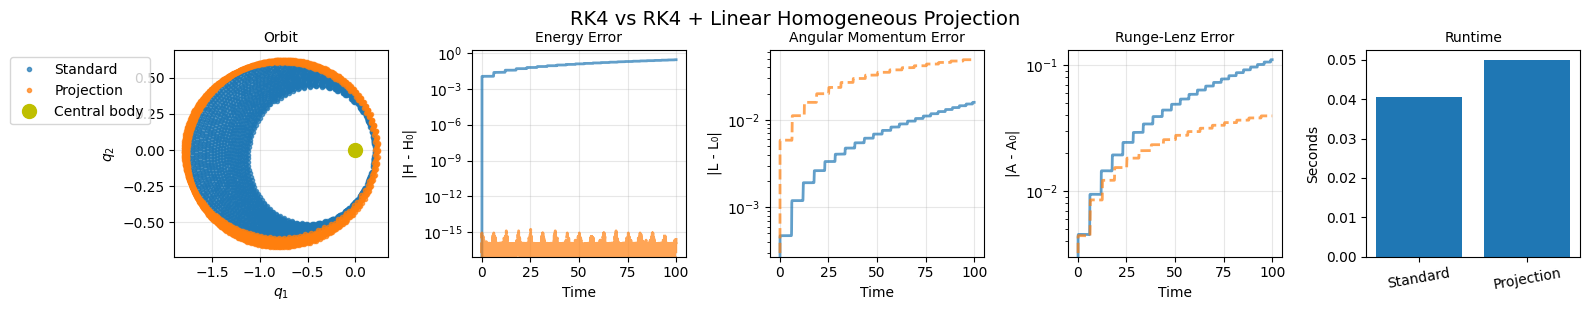

In [6]:
# Define plotting function to compare results 
def plot_kepler_comparison(sol_std, sol_proj, time_std, time_proj, y0, label_std='Standard', label_proj='Projection', itol=None, itol_label='Invariant tolerance'):
    t_proj = sol_proj.t
    y_proj = sol_proj.y.T

    H_proj = np.array([energy(*y_proj[i]) for i in range(len(t_proj))])
    L_proj = np.array([angular_momentum(*y_proj[i]) for i in range(len(t_proj))])
    A_proj = np.array([runge_lenz_component(*y_proj[i]) for i in range(len(t_proj))])

    t_std = sol_std.t
    y_std = sol_std.y.T  # Transpose to get [n_steps, n_vars]

    H_std = np.array([energy(*y_std[i]) for i in range(len(t_std))])
    L_std = np.array([angular_momentum(*y_std[i]) for i in range(len(t_std))])
    A_std = np.array([runge_lenz_component(*y_std[i]) for i in range(len(t_std))])
    
    H0 = energy(*y0)
    L0 = angular_momentum(*y0)
    A0 = runge_lenz_component(*y0)


    fig, axes = plt.subplots(1, 5, figsize=(16, 3))

    # Orbits
    ax = axes[0]
    ax.plot(y_std[:, 0], y_std[:, 1], '.', alpha=0.7, label=label_std, lw=2)
    ax.plot(y_proj[:, 0], y_proj[:, 1], '.', alpha=0.7, label=label_proj, lw=2)
    ax.plot(0, 0, 'yo', markersize=10, label='Central body')
    ax.set_xlabel('$q_1$', fontsize=10)
    ax.set_ylabel('$q_2$', fontsize=10)
    ax.set_title('Orbit', fontsize=10)
    ax.grid(alpha=0.3)
    ax.legend(bbox_to_anchor=(-0.8, 1), loc='upper left')

    # Energy error
    ax = axes[1]
    ax.semilogy(t_std, np.abs(H_std - H0), '-', alpha=0.7, label=label_std, lw=2)
    ax.semilogy(t_proj, np.abs(H_proj - H0), '--', alpha=0.7, label=label_proj, lw=2)
    ax.axhline(itol, color='gray', linestyle='--', label=itol_label) if itol is not None else None
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('|H - H₀|', fontsize=10)
    ax.set_title('Energy Error', fontsize=10)
    ax.grid(alpha=0.3)

    # Angular momentum error
    ax = axes[2]
    ax.semilogy(t_std, np.abs(L_std - L0), '-', alpha=0.7, label=label_std, lw=2)
    ax.semilogy(t_proj, np.abs(L_proj - L0), '--', alpha=0.7, label=label_proj, lw=2)
    ax.axhline(itol, color='gray', linestyle='--', label=itol_label) if itol is not None else None
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('|L - L₀|', fontsize=10)
    ax.set_title('Angular Momentum Error', fontsize=10)
    ax.grid(alpha=0.3)
    
    # Runge-Lenz error
    ax = axes[3]
    ax.semilogy(t_std, np.abs(A_std - A0), '-', alpha=0.7, label=label_std, lw=2)
    ax.semilogy(t_proj, np.abs(A_proj - A0), '--', alpha=0.7, label=label_proj, lw=2)
    ax.axhline(itol, color='gray', linestyle='--', label=itol_label) if itol is not None else None
    ax.set_xlabel('Time', fontsize=10)
    ax.set_ylabel('|A - A₀|', fontsize=10)
    ax.set_title('Runge-Lenz Error', fontsize=10)
    ax.grid(alpha=0.3)
    
    
    ax = axes[4]
    ax.bar([label_std, label_proj], [time_std, time_proj])
    ax.tick_params(axis='x', rotation=10)
    ax.set_ylabel('Seconds', fontsize=10)
    ax.set_title('Runtime', fontsize=10)

    plt.tight_layout()
    return fig, axes


# Call the function with current variables
fig, axes = plot_kepler_comparison(sol_std, sol_proj, time_std, time_proj, y0)
fig.suptitle('RK4 vs RK4 + Linear Homogeneous Projection', y=1.02, fontsize=14)

#

### Observation

- **Energy**: Preserved exactly to machine precision

The linear homogeneous projection for angular momentum works perfectly because:
1. L is truly homogeneous: $L(\lambda q, \lambda p) = \lambda^2 L(q,p)$  
2. We can simply scale the state to restore L without affecting other properties too much

## Step 4: Multiple Invariants with `HomogeneousProjector`

To preserve all three invariants (energy, angular momentum, and Runge-Lenz), we use the more general `HomogeneousProjector` class.

Note that you can pass in the symnbolic invariants and HomogeneousProjector will calcualte the gradients symbolically. Otherwise, you can pass in the precomputed gradients. 

In [7]:
# Define symbolic variables (required for HomogeneousProjector)
import sympy as sp
q1, q2, p1, p2 = sp.symbols('q1 q2 p1 p2', real=True)
vars_sym = [q1, q2, p1, p2]

# Define symbolic invariants
r = sp.sqrt(q1**2 + q2**2)
H_sym = sp.Rational(1,2) * (p1**2 + p2**2) - 1/r
L_sym = q1*p2 - q2*p1
A_sym = p2 * L_sym - q1 / r

itol = 1e-8

# Create projector for ALL THREE invariants with maximum of 3 projector iterations or until all invariants are within itol
three_inv_projector = HomogeneousProjector(
    invariants=[H_sym, L_sym, A_sym],
    variables=vars_sym,
    initial_state=y0,
    max_iterations=3,
    tolerance=itol,
    integrator='rk2',
)

# Wrap integrator
def rk4_with_three_proj(x, h, f):
    """RK4 step followed by projection onto all three invariants"""
    x_new = rk4(x, h, f)
    return three_inv_projector.project(x_new)


### Test: Preserving All Three Invariants

In [8]:
print("Running RK4 + three invariants projection...")
t0 = time()
sol_three = solve_ivp_fixed_step(
    f=kepler_dynamics,
    t_span=t_span,
    y0=y0,
    method=rk4_with_three_proj,
    h=h
)
time_three = time()-t0
print(f"RK4 + three invariants projection took {time_three:.3f} seconds")

Running RK4 + three invariants projection...
RK4 + three invariants projection took 0.182 seconds


Text(0.5, 1.02, 'RK4 vs RK4 + Pseudo-Nonlinear-Homogeneous Projection of all three invariants')

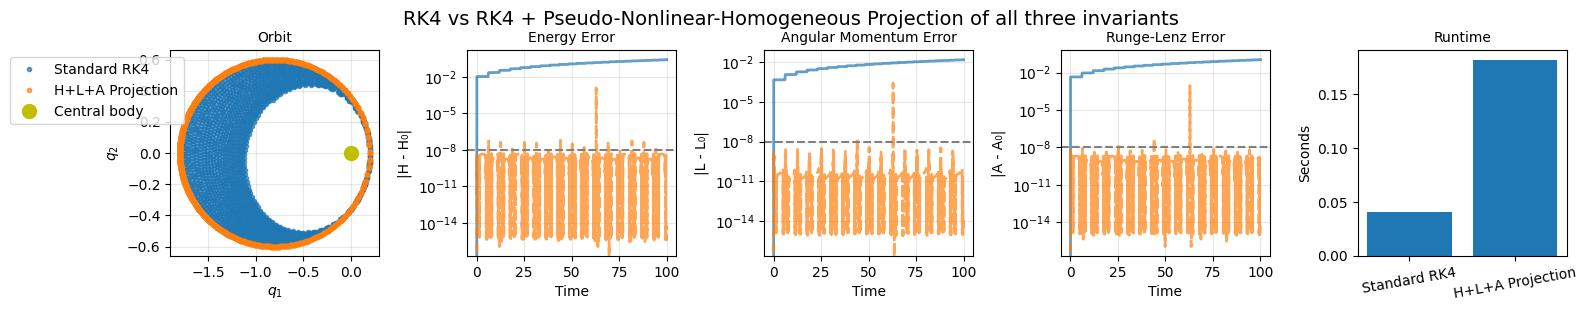

In [9]:
fig, ax = plot_kepler_comparison(
    sol_std, sol_three, time_std=time_std, time_proj=time_three, y0=y0,
    label_std='Standard RK4',
    label_proj='H+L+A Projection',
    itol=itol,
    itol_label='Invariant tolerance'
)
fig.suptitle('RK4 vs RK4 + Pseudo-Nonlinear-Homogeneous Projection of all three invariants', y=1.02, fontsize=14)


## Step 5: Adaptive Methods with `solve_ivp`

Now let's compare adaptive methods (DOP853) with and without projection using `homproj.adaptive.solve_ivp`.

In [ ]:
# Import adaptive solver
from scipy.integrate import solve_ivp as scipy_solve_ivp
from homproj import solve_ivp

eccentricity = 0.999 # High eccentricity for more challenging case
y0 = np.array([(1 - eccentricity), 0.0, 0.0, np.sqrt((1 + eccentricity) / ((1 - eccentricity)))])
t_span = (0, 10000)

# Standard DOP853 (no projection) - use scipy directly
print("Running standard DOP853 (takes up to 30s)...")
start = time()
sol_dop_std = scipy_solve_ivp(
    fun=kepler_dynamics,
    t_span=t_span,
    y0=y0,
    method='DOP853',
    rtol=1e-6,
    atol=1e-6
)
time_dop_std = time() - start

print(f"Standard DOP853 completed in {time_dop_std:.2f} seconds.")

Running standard DOP853...
Standard DOP853 completed in 22.55 seconds.
Standard DOP853 completed in 22.55 seconds.


In [11]:
# DOP853 with projection (preserving all three invariants)
print("\nRunning DOP853 + three invariants projection...")
start = time()
sol_dop_proj = solve_ivp(
    fun=kepler_dynamics,
    t_span=t_span,
    y0=y0,
    method='DOP853',
    rtol=1e-6,
    atol=1e-6,
    invariants=[H_sym, L_sym, A_sym],
    variables=vars_sym,
    max_iterations=1,  # Number of projection iterations
)
time_dop_proj = time() - start

print(f"DOP853 with projection completed in {time_dop_proj:.2f} seconds.")



Running DOP853 + three invariants projection...
DOP853 with projection completed in 16.11 seconds.
DOP853 with projection completed in 16.11 seconds.


Text(0.5, 1.02, 'DOP853 vs DOP853 + Pseudo-Nonlinear-Homogeneous Projection of all three invariants')

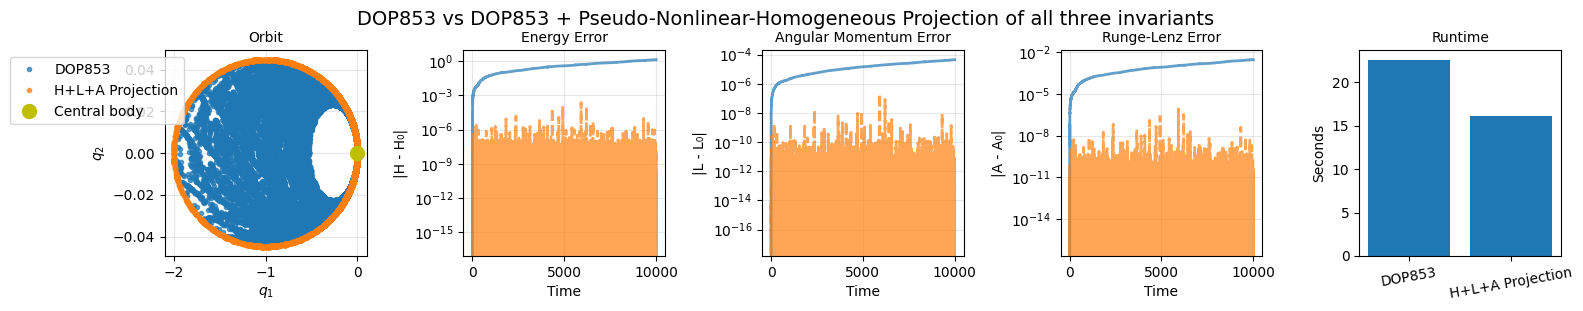

In [12]:
fig, ax = plot_kepler_comparison(
    sol_dop_std, sol_dop_proj,
    time_std=time_dop_std,
    time_proj=time_dop_proj,
    y0=y0,
    label_std='DOP853',
    label_proj='H+L+A Projection',
)
fig.suptitle('DOP853 vs DOP853 + Pseudo-Nonlinear-Homogeneous Projection of all three invariants', y=1.02, fontsize=14)
